# KMeans clustering #

This notebook is used for KMeans clustering of previously concatenated LSD and placebo data. It includes:

1) concatenating all data into one large array
2) KMeans clustering
3) plotting KMeans clustering measures: silhouette score, within-cluster sum of squares, between-cluster sum of squares, variance explained
4) plotting gain in variance explained - key criterion for choosing the number of brain states
5) calculating absent states characteristics

Total length of $N$ was equal to 18 228 (9114 time points from both LSD and PLCB sessions).

**Last update:** 29.08.2021

### Step 0: Loading libraries ###

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist,pdist
from sklearn import metrics
%matplotlib inline

### Step 1: Loading and concatenating timeseries ###

In [2]:
#Loading data
data = np.load('data/fixed_concat_Schaefer_2018_cleaned_standardized_timeseries.npy', allow_pickle = True).item()

concat_timeseries_plcb = data['sessions']['PLCB']['timeseries']
concat_timeseries_lsd = data['sessions']['LSD']['timeseries']

X = np.concatenate((concat_timeseries_plcb, concat_timeseries_lsd))
X.shape

(18228, 400)

### Step 2: Clustering timeseries into brain states using KMeans algorithm ###

In [3]:
def kmeans_clustering(X, k_min, k_max, n_init, random_state):
    
    ''' 
    This function performs KMeans clustering on k clusters ranging from k_min to k_max and 
    for each k calculates brain states labels, within-cluster sum of squares,
    total sum of squares, between-cluster sum of squares, silhouette score and variance explained.
    
    Args:
        X - 2D array with training data
        k_min - minimum number of clusters (int)
        k_max - maximum number of clusters (int)
        n_init - number of times the algorithm will be run with different centroid seeds (int)
        random_state - random number generation for centroid initialization
    
    Return:
        clustering_output - dictionary including:
            kmeans_model - KMeans objects storing clustering setup and outupts
            within_cluster_ss - within-cluster sum of squares (ndarray)
            total_ss - total sum of squares (ndarray)
            between_cluster_ss - between cluster sum of squares (ndarray)
            variance_explained - amount of data each number of clusters explains (ndarray)
            silhouette - silhouette score (ndarray)
            k - list of cluster range (list)
            n_init - number of times the algorithm will be run with different centroid seeds (int)
            
    '''
    
    K = range(k_min, k_max+1)

    # K-means clustering
    kmeans_model = [KMeans(n_clusters=k, n_init=n_init, random_state=random_state).fit(X) for k in K]
    
    centroids = [k.cluster_centers_ for k in kmeans_model] # Get centers of clusters
    k_euclid = [cdist(X, cent, 'euclidean') for cent in centroids] # Calculate distance between clusters
    dist = [np.min(ke, axis=1) for ke in k_euclid] # Calcuate minimal distance between clusters 
    
    within_cluster_ss = [sum(d**2) for d in dist] # Within-cluster sum of squares
    total_ss = sum(pdist(X)**2)/X.shape[0] # Total sum of squares
    between_cluster_ss = total_ss - within_cluster_ss # Between-cluster sum of squares
    
    # Silhouette score
    silhouette = np.array([silhouette_score(X, lab.labels_, metric='euclidean') for lab in kmeans_model])

    # Saving dictionary with all metadata
    clustering_output = {'kmeans_model': kmeans_model, 
                     'within_cluster_ss': within_cluster_ss, 
                     'total_ss': total_ss,
                     'between_cluster_ss': between_cluster_ss,
                     'variance_explained': between_cluster_ss/total_ss*100,
                   'silhouette': silhouette,
                    'k': list(K),
                    'n_init': n_init}
    
    return clustering_output

### Step 3: Running the function ###

In [4]:
# Running function and saving output
clustering_output = data.copy()
clustering_output['kmeans'] = kmeans_clustering(X, k_min=2, k_max=14, n_init=100, random_state=42)

In [7]:
#Checking the output and saving the data
clustering_output['kmeans']
np.save('data/clustering_output.npy', clustering_output)

### Step 4: Plotting KMeansMesures ###

In [8]:
def plotting_kmeans_measures(clustering_output):
    
    ''' 
    This function visualizes within-cluster sum of squares, between-cluster sum of squares, 
    silhouette score and variance explained, given the data from 
    KMeans clustering.
    
    Args:
        clustering output - dictionary with all clustering results (dict)
    
    Return:
        KMeans measures visualization
    '''
    
    #Creating the plot
    fig, axes = plt.subplots(2, 2,figsize = (10,8))
    axs = axes.flatten()

    measures = {'within_cluster_ss': 'Within-cluster sum of squares', 
                'between_cluster_ss': 'Between-cluster sum of squares', 
                'silhouette': 'Silhouette score' , 
                'variance_explained': 'Variance explained' }

    x = clustering_output['kmeans']['k']

    for i, (measure, desc) in enumerate(measures.items()):
        axs[i].plot(x, clustering_output['kmeans'][measure], color = 'c')
        axs[i].set_title(desc, size = 14)
        axs[i].set_xlabel('Number of clusters', size = 12)
        axs[i].grid()
        axs[i].set_xticks(x)

    #Custimizing the plot
    fig.suptitle('KMeans measures',size = 20)
    fig.tight_layout()
    fig.subplots_adjust(top = 0.87, hspace = 0.4)

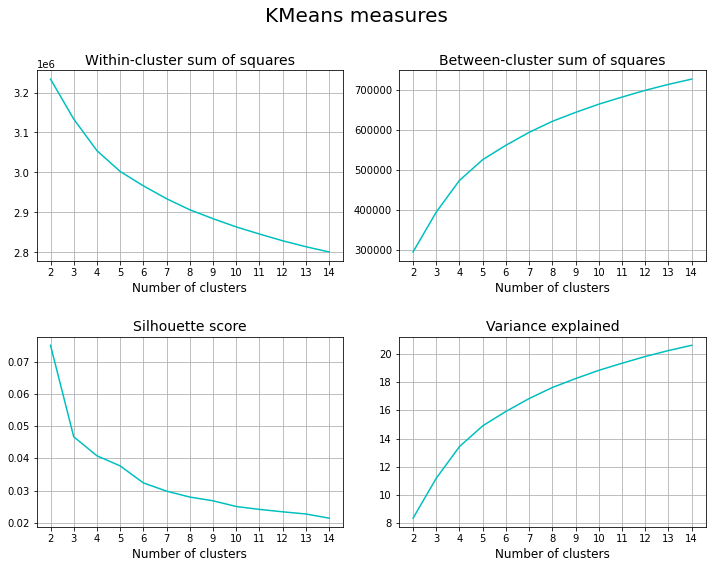

In [22]:
#Running the function and plotting the measures
plotting_kmeans_measures(clustering_output)
plt.savefig('Figures/kmeans_measures.png', dpi=300, bbox_inches='tight')

### Step 5: Plotting gain in variance explained ###

In [10]:
#Creating the function
def plot_variance_explained_gain(clustering_output):
    
    ve = clustering_output['kmeans']['variance_explained']
    
    diff_all = []

    for i in range(len(ve)-1):
        if i == 0:
            diff_all.append(ve[i])
        else:
            diff = ve[i+1] - ve[i]
            diff_all.append(diff)
    
    plt.plot(diff_all, color ='c')
    plt.grid()
    plt.title('Gain in variance explained', size = 14)
    plt.xlabel('Number of clusters', size = 12)

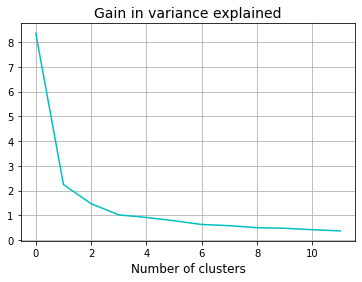

In [23]:
#Running the function
plot_variance_explained_gain(clustering_output)
plt.savefig('Figures/ve_gain.png', dpi=300, bbox_inches='tight')

### Step 6: Saving the data corresponding to the chosen number of states ###

In [12]:
#Saving data for 4 states
brain_states_4 = clustering_output['kmeans']['kmeans_model'][2].labels_
np.save('data/fixed_4_cleaned_brain_states_Schaefer_2018.npy', brain_states_4)

### Step 7: Preparing data for absent states analysis ###

In [13]:
#Loading data
data_absent = np.load('/home/iga/BrainStates/ds003059/Schaefer_2018_cleaned_standardized_timeseries.npy', allow_pickle = True).item()
timeseries_plcb = data_absent['sessions']['PLCB']['timeseries']

#Getting the data
timeseries_plcb = data_absent['sessions']['PLCB']['timeseries']
n_sub = timeseries_plcb.shape[0]
n_runs = timeseries_plcb.shape[1]
t_len = timeseries_plcb.shape[3]

keys = list(clustering_output['kmeans']['k'])
len_states = X.shape[0]
bs_shape = len(keys)


#Retrieving data for each subject with brain states labels
brain_states = np.zeros((bs_shape,len_states))

for i in keys:
    brain_states[i-2,:] = clustering_output['kmeans']['kmeans_model'][i-2].labels_

    
brain_states_plcb = brain_states[:, :9114]
brain_states_lsd = brain_states[:, 9114:]

bs_all = np.concatenate((brain_states_plcb, brain_states_lsd), axis =1)

#Saving the whole timeseries after the clustering
print(bs_all.shape)
np.save('data/fixed_bs_all.npy', bs_all)

#Selecting placebo data
bs_plcb_run1 = brain_states_plcb[:,:3255]
bs_plcb_run2 = brain_states_plcb[:,3255:5859]
bs_plcb_run3 = brain_states_plcb[:,5859:]

bs_plcb_run1_res = bs_plcb_run1.reshape(brain_states.shape[0],15,t_len)
bs_plcb_run2_res = bs_plcb_run2.reshape(brain_states.shape[0],12,t_len)
bs_plcb_run3_res = bs_plcb_run3.reshape(brain_states.shape[0],15,t_len)

#Selecting LSD data
bs_lsd_run1 = brain_states_lsd[:,:3255]
bs_lsd_run2 = brain_states_lsd[:,3255:5859]
bs_lsd_run3 = brain_states_lsd[:,5859:]

bs_lsd_run1_res = bs_lsd_run1.reshape(brain_states.shape[0],15,t_len)
bs_lsd_run2_res = bs_lsd_run2.reshape(brain_states.shape[0],12,t_len)
bs_lsd_run3_res = bs_lsd_run3.reshape(brain_states.shape[0],15,t_len)


#Saving the data
brain_states_res = {'PLCB': {'run_1': bs_plcb_run1_res, 'run_2': bs_plcb_run2_res, 'run_3': bs_plcb_run3_res}, 
                                 'LSD': {'run_1': bs_lsd_run1_res, 'run_2': bs_lsd_run2_res, 'run_3': bs_lsd_run3_res }}

np.save('data/fixed_brain_states_reshaped.npy', brain_states_res)

(13, 18228)


### Step 8: Absent states analysis ###

In [14]:
def absent_states(bs_timeseries):    
    """
    This function counts number of absent brain states for each cluster and plots the result
           
    
    Args:
        bs_timeseries: 4D timeseries with dimension: (n_clusters, n_subjects, n_timepoints (length of timeseries)) 
    
    Return
        Seaborn plot with number of absent states per each cluster
   """     
    
    import pandas as pd
    import numpy as np
    import seaborn as sns
    %matplotlib inline
    
    ses = ['PLCB', 'LSD']
    
    absent_states_df = pd.DataFrame()
    for i in range(bs_timeseries.shape[1]):
        for k in range(bs_timeseries.shape[0]):
            bs_labels = bs_timeseries[k,i,:]
            bs_states = len(np.unique(bs_labels))
            absent = k + 2 - bs_states
            absent_states_df = pd.concat([absent_states_df, pd.DataFrame({"Subject":f"sub-{i+1:02}", "k":k+2, 'Absent':absent}, index =[0])], axis=0)
                
    absent_states = absent_states_df
    sns.catplot(x = 'k', y = 'Absent', data=absent_states, kind = 'bar')
    plt.title(' Number of absent states')

### Step: 8 Running the absent state function for placebo session ###

Plotting absent states for run_1


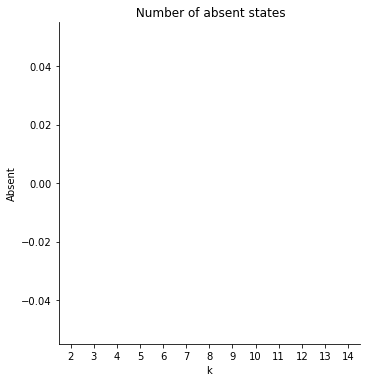

Plotting absent states for run_2


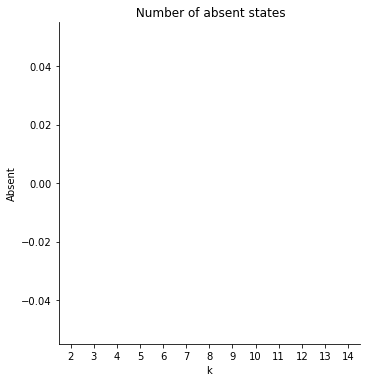

Plotting absent states for run_3


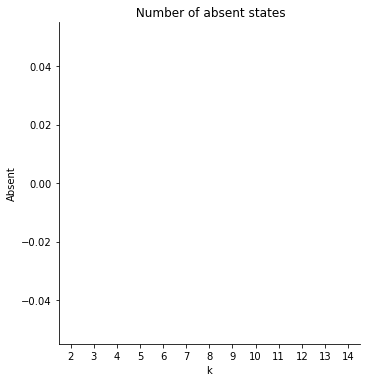

In [24]:
#Running the absent states function for placebo session
for k in brain_states_res['PLCB']:
    print(f'Plotting absent states for {k}')
    absent_states(brain_states_res['PLCB'][k])
    plt.savefig(f'Figures/plcb_absent_{k}.png', dpi=300, bbox_inches='tight')
    plt.show()

### Step 9: Running the absent states function for LSD sessions ###

Plotting absent states for run_1


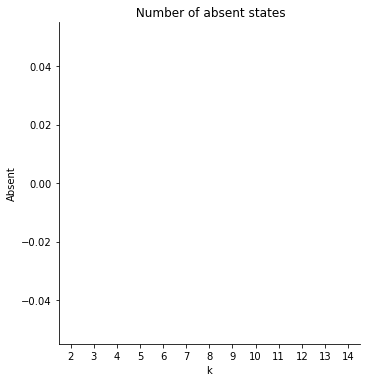

Plotting absent states for run_2


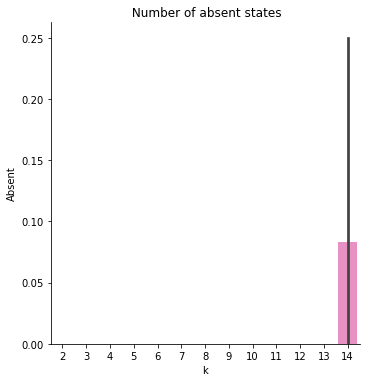

Plotting absent states for run_3


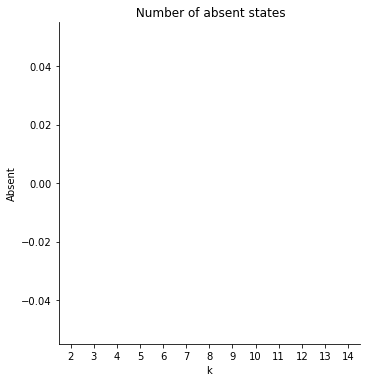

In [25]:
#Running the absent states function for LSD session
for k in brain_states_res['LSD']:
    print(f'Plotting absent states for {k}')
    absent_states(brain_states_res['LSD'][k])
    plt.savefig(f'Figures/lsd_absent_{k}.png', dpi=300, bbox_inches='tight')
    plt.show()